In [ ]:
pip install striprtf

In [ ]:
import csv
from striprtf.striprtf import rtf_to_text
import os

def convert_rtf_to_csv(rtf_file, csv_file):
    # Open the RTF file and read its content
    with open(rtf_file, 'r', encoding='utf-8') as file:
        rtf_content = file.read()

    # Convert RTF to plain text
    text_content = rtf_to_text(rtf_content)

    # Split the text into lines
    lines = text_content.split('\n')

    # Write lines to CSV
    with open(csv_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for line in lines:
            writer.writerow([line])

# Specify the directory where your RTF files are located
rtf_directory = '/content/rtf'

# Specify the directory where you want to save the CSV files
csv_directory = '/content/outputcsv'

# Loop through all files in the RTF directory
for filename in os.listdir(rtf_directory):
    # Check if the file has .rtf extension
    if filename.endswith('.rtf'):
        # Construct the full path to the file
        rtf_file = os.path.join(rtf_directory, filename)
        
        # Construct the name and full path for the CSV file
        csv_filename = filename.replace('.rtf', '.csv')
        csv_file = os.path.join(csv_directory, csv_filename)

        # Convert the RTF file to CSV
        convert_rtf_to_csv(rtf_file, csv_file)

In [ ]:
import pandas as pd
import nltk
import re
from gensim import corpora, matutils
from gensim.models import TfidfModel, LdaModel, Word2Vec, KeyedVectors
from gensim.similarities import MatrixSimilarity
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

In [2]:
# download necessary resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the data
df = pd.read_csv('/content/Files (100)-1.csv', encoding='latin-1')
df = df.rename(columns={'Unnamed: 0': 'txt'})

In [4]:
# Drop irrelevant rows
df = df.drop(df.index[:960], axis=0)
df = df.dropna()

In [5]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url_text = url_pattern.sub(r'', text)
    return no_url_text

In [6]:
# instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [7]:
# define a function to convert nltk pos-tag to wordnet pos-tag
def nltk_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [8]:
# define a function to apply lemmatization
def apply_lemmatization(text):
    nltk_pos_tagged = nltk.pos_tag(word_tokenize(text))
    wordnet_pos_tagged = map(lambda x: (x[0], nltk_to_wordnet_pos(x[1])), nltk_pos_tagged)
    lemmatized_words = [lemmatizer.lemmatize(word, pos) if pos else word for word, pos in wordnet_pos_tagged]
    return " ".join(lemmatized_words)

In [9]:
stop_words = set(stopwords.words("english"))

In [10]:
# Add additional user-defined stop words
stopword1 = ['the', 'to', 'and', 'of', 'a', 'in', 'that', 'for', 'is', 'it', 'on', 'have', 'by', 'are', 'with' ,'you', 'â', 'be', 
             'as', 'care', 'need', 'said', 'also', 'year', 'cost', 'would', 'make', 'increase',  'pay', 'support', 'end', 'system', 
             'get', 'work', 'new', 'one', 'test', 'take', 'funding', 'money', 'percent', 'plan', 'right', 'go', 'sol', 'board', 
             'include', 'like', 'part', 'provide', 'us', 'give', 'way', 'increase', 'house', 'news', 'make', 'want', 'per', 'test', 'spend', 
             'classroom', 'must', 'look', 'use', 'say', 'need', 'change', 'come', 'result', 'many', 'learn', '1',  'raise' , 'continue',  
             'spending', 'see', 'number', 'great', 'word', 'much', 'help',  'know', 'improve', 'first', 'find',  'every','time','think']
stop_words = stop_words.union(stopword1)

In [11]:
# Data Cleaning
df['Cleaned txt'] = df['txt'].str.replace(r'[^\w\s]', '')  # remove punctuation
df['Cleaned txt'] = df['Cleaned txt'].str.lower()  # convert to lowercase
df['Cleaned txt'] = df['Cleaned txt'].apply(apply_lemmatization)  # apply lemmatization
df['Cleaned txt'] = df['Cleaned txt'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))  # remove stopwords

<ipython-input-11-da0a4b61582b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cleaned txt'] = df['txt'].str.replace(r'[^\w\s]', '')  # remove punctuation


In [12]:
# Define the corpus
docs_clean = df['Cleaned txt']
corpus_clean = [doc.split() for doc in docs_clean]

In [13]:
# Create the dictionary
dictionary_clean = corpora.Dictionary(corpus_clean)
ids_to_remove = [tokenid for tokenid, token in dictionary_clean.items() if token.isdigit()]

In [14]:
# Compute the word frequency
flat_corpus = [token for doc in corpus_clean for token in doc]
word_freq = Counter(flat_corpus)

# Print the top 100 most frequent terms
top_100_words = dict(word_freq.most_common(100))
print("Top 100 words in the corpus: ", top_100_words)

Top 100 words in the corpus:  {'school': 1740, 'education': 985, 'state': 918, 'student': 845, 'teacher': 757, 'district': 719, 'public': 624, '2019': 536, 'charter': 316, 'tax': 314, 'fund': 311, 'health': 276, 'prescription': 273, 'program': 265, 'report': 229, 'document': 224, 'high': 212, 'federal': 209, 'service': 197, 'drug': 190, 'budget': 188, 'policy': 185, 'child': 184, 'k12': 182, 'million': 178, 'government': 168, 'virginia': 166, 'billion': 162, 'warren': 161, 'well': 154, 'national': 150, 'good': 149, 'people': 145, 'drughealth': 129, 'law': 124, 'local': 122, 'performance': 122, 'october': 121, 'family': 121, 'county': 121, 'issue': 120, 'community': 116, 'copyright': 115, 'require': 115, 'insurance': 115, 'illinois': 114, 'kid': 113, 'ensure': 113, 'city': 113, 'panel': 111, 'could': 110, 'less': 110, 'teach': 110, 'call': 109, 'candidate': 108, 'newstex': 108, 'body': 106, 'back': 106, 'best': 106, 'price': 105, 'outcome': 105, 'proposal': 104, 'thing': 104, 'base': 10

In [15]:
# Filter out the identified terms
dictionary_clean.filter_tokens(bad_ids=ids_to_remove)

# Create the document term matrix
DFM_clean = [dictionary_clean.doc2bow(doc) for doc in corpus_clean]

# Calculate the TF-IDF matrix
tfidf_model = TfidfModel(DFM_clean)
tfidf_matrix = tfidf_model[DFM_clean]

In [16]:
# LDA model
lda_model = LdaModel(corpus=DFM_clean, num_topics=4, id2word=dictionary_clean, passes=10, random_state=42)

In [17]:
# Print the 8 most relevant terms per topic
topics = lda_model.print_topics(num_topics=4, num_words=8)
for topic in topics:
    print(topic)

(0, '0.019*"school" + 0.015*"district" + 0.014*"state" + 0.014*"student" + 0.011*"education" + 0.010*"tax" + 0.006*"high" + 0.005*"kid"')
(1, '0.018*"health" + 0.013*"drug" + 0.011*"service" + 0.011*"october" + 0.010*"prescription" + 0.010*"copyright" + 0.009*"state" + 0.009*"district"')
(2, '0.017*"document" + 0.014*"school" + 0.011*"teacher" + 0.010*"education" + 0.008*"public" + 0.008*"state" + 0.007*"body" + 0.007*"panel"')
(3, '0.044*"school" + 0.022*"teacher" + 0.021*"education" + 0.016*"public" + 0.015*"student" + 0.014*"state" + 0.011*"charter" + 0.007*"district"')


In [18]:
# Summarize the topics
topic_summaries = []
for topic in lda_model.show_topics(formatted=False, num_topics=4, num_words=8):
    summary = " ".join([word[0] for word in topic[1]])
    topic_summaries.append(summary)
print("\nTopic Summaries:")
for idx, summary in enumerate(topic_summaries):
    print(f"Topic {idx + 1}: {summary}")


Topic Summaries:
Topic 1: school district state student education tax high kid
Topic 2: health drug service october prescription copyright state district
Topic 3: document school teacher education public state body panel
Topic 4: school teacher education public student state charter district


In [19]:
# Train the Word2Vec model on your corpus
model = Word2Vec(corpus_clean, min_count=1, vector_size=100, workers=4)

# List of words to check
words = ['decentralization', 'accountability', 'devolution', 'delegation', 'authority', 'equity']

for word in words:
    if word in model.wv.index_to_key: # Check if the word exists in the model vocabulary
        # Find the top-8 most similar words to 'word'
        top_8_related_terms = model.wv.most_similar(positive=word, topn=8)
        print(f"For the word '{word}', the 8 most related terms are:")
        for term, similarity in top_8_related_terms:
            print(f"{term}: {similarity}")
    else:
        print(f"The word '{word}' does not exist in the model vocabulary.")

The word 'decentralization' does not exist in the model vocabulary.
For the word 'accountability', the 8 most related terms are:
kid: 0.9994142055511475
thing: 0.9994028210639954
community: 0.9993934631347656
group: 0.999388575553894
private: 0.9993858337402344
legislature: 0.9993762969970703
whether: 0.9993720650672913
parent: 0.9993581771850586
The word 'devolution' does not exist in the model vocabulary.
For the word 'delegation', the 8 most related terms are:
prek: 0.9697079658508301
match: 0.969693660736084
inequality: 0.9693700671195984
nation: 0.9692626595497131
gop: 0.9691790342330933
security: 0.9691643714904785
dozen: 0.9691464900970459
rural: 0.9691302180290222
For the word 'authority', the 8 most related terms are:
illinois: 0.998328447341919
lead: 0.998310387134552
del: 0.9982904195785522
organization: 0.9982476830482483
law: 0.99824458360672
create: 0.9982420206069946
move: 0.9982298612594604
good: 0.9982264637947083
For the word 'equity', the 8 most related terms are:
ho

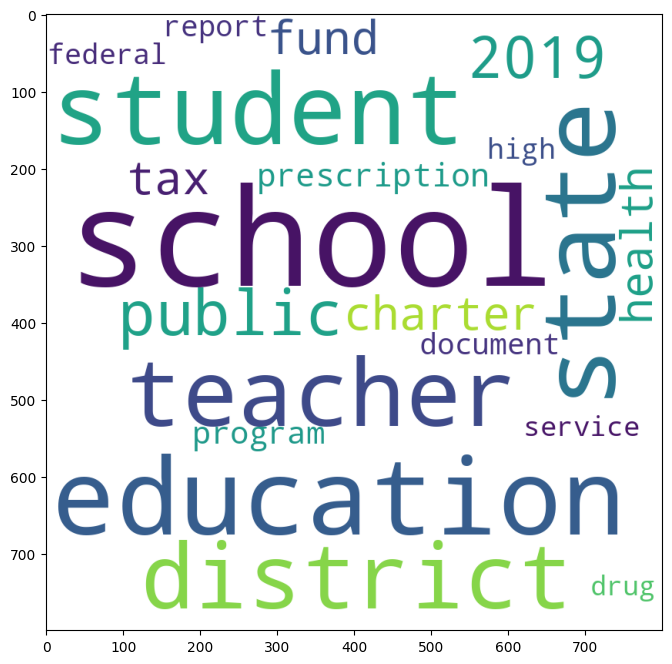

In [20]:
# Wordcloud
flat_corpus = [token for doc in corpus_clean for token in doc]
word_freq = Counter(flat_corpus)
top_20_words = dict(word_freq.most_common(20))
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(top_20_words)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)